# Notebook magique with AutoML

TO DO:
- remove outliers: implement new fucntion + get right percentage
- test different numbers of topics and clusters 

See 
https://github.com/parklize/cikm2020-analyticup?fbclid=IwAR0Ti_pF7HrIO5ELFlvA1b2FEL_D68xlu_XdXeFxyARzBfY5U7a040klHTM

In [65]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit  # pip install verstack


# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")


Split data

In [66]:
# split data
X_train, X_test, y_train, y_test = scsplit(
    train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)


## Outliers

In [67]:
# remove outliers with quartile
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df




# 2% of outliers are removed for 3 variables. In total 5 to 6% of  data is removed

q = raw_data_mod_2["UserFollowersCount"].quantile(0.98)
data_1 = raw_data_mod_2[raw_data_mod_2["UserFollowersCount"]<q]


q2 = data_1["UserFriendsCount"].quantile(0.98)
data_2 = data_1[data_1["UserFriendsCount"]<q2]


q3 = data_2["UserTweetCount"].quantile(0.98)
data_3 = data_2[data_2["UserTweetCount"]<q3]
data_3.info()



In [68]:
def feature_engineering(in_df):
    rs_df = in_df

    # mentions is always empty -> DROP Mention
    rs_df = rs_df.drop(['mentions'], axis=1)

    # add a column to data which counts url
    rs_df['url_count'] = rs_df['urls'].str.count('http')
    rs_df = rs_df.drop(['urls'], axis=1)
    # add a column to data which gives length of hashtags
    # TO DO
    # add columns to data which makes ratios
    rs_df['followers_friends'] = rs_df['followers_count'] / \
        (rs_df['friends_count'].apply(lambda x: x+1))
    
    return rs_df


In [69]:
from datetime import datetime


def time_engineering(in_df):
    rs_df = in_df
    rs_df["hour"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).hour))
    rs_df["day"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    rs_df["week_in_month"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).day)//7)
        
    rs_df.drop(['timestamp'], axis=1)

    return rs_df


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
def extract_topic(df):
    rs_df = df
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    #join text and hashtags
    rs_df['total_text'] = rs_df['text'] + ' ' + rs_df['hashtags']
    vectorizer = TfidfVectorizer(min_df=1, max_features=None, stop_words=stopwords.words('french'))
    vector = vectorizer.fit_transform(df['text'])
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(vector)
    topic=svd.transform(vector)
    rs_df['topic_1'] = topic[:,0]
    rs_df['topic_2'] = topic[:,1]
    rs_df['topic_3'] = topic[:,2]
    rs_df['topic_4'] = topic[:,3]
    rs_df['topic_5'] = topic[:,4]
    return rs_df

In [71]:
from textblob import TextBlob  # pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer


def text_engineering(in_df):
    rs_df = in_df
    # add columns related to sentiment analysis
    rs_df['polarity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    rs_df['subjectivity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])
    # drop the text column
    rs_df = rs_df.drop(['text'], axis=1)

    return rs_df


In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


def hashtags_engineering(in_df):
    rs_df = in_df
    # make a string of the list
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))

    # has hashtags or not
    rs_df['has_hashtags'] = rs_df['hashtags'].apply(
        lambda x: 0 if x == '' else 1)

    # drop the hashtags column
    rs_df = rs_df.drop(['hashtags'], axis=1)
    return rs_df


In [73]:
#import kmeans
from sklearn.cluster import KMeans
def extract_cluster(df,columns):
    rs_df = df
    rs_df['cluster'] = KMeans(n_clusters=100, random_state=0).fit_predict(rs_df[columns].values)
    return rs_df

## Scaler

In [74]:
def logtransformdrop(dataframe, cols):
    for col in cols:
        dataframe[col] = dataframe[col].apply(lambda x: np.log10(int(x)+1))
    return dataframe


## Data processing

In [75]:
col = ['TweetID', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'has_hashtags', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']#add cluster


In [76]:
new_X_train = feature_engineering(X_train)
new_X_train = time_engineering(new_X_train)
new_X_train = extract_topic(new_X_train)
new_X_train = text_engineering(new_X_train)
new_X_train = hashtags_engineering(new_X_train)
new_X_train = extract_cluster(new_X_train,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_train = new_X_train.reindex(columns=col)
new_X_train.drop(['topic_1','topic_2','topic_3','topic_4','topic_5'],axis=1).head()


,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,has_hashtags,cluster
53204,307171,15,88,0,1605,0,1,0.168539,16,1,2,0.140,0.20,0,73
44617,431419,111718,9235,7,45365,1,1,12.095929,15,3,2,0.300,0.20,1,49
340343,771605,2831,4806,2,146518,0,1,0.588933,15,6,1,-0.135,0.15,0,55
96270,646233,7016,1969,1,25438,0,1,3.561421,16,3,1,-0.200,0.40,0,99
50604,82261,1083,3258,0,17173,0,0,0.332311,23,1,2,0.100,0.30,0,50


In [84]:

remove=['TweetID', 'verified', 'url_count', 'week_in_month','day', 'polarity', 'subjectivity', 'has_hashtags', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

## Flaml

In [85]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'mae',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
    # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'regression',  # task type
    # ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
    'estimator_list': ['rf'],
    "seed": 7654321,    # random seed
}

automl.fit(new_X_train.drop(remove, axis=1), y_train, **settings)
# Print the best model
print(automl.model.estimator)


[flaml.automl: 11-23 15:53:22] {2600} INFO - task = regression
[flaml.automl: 11-23 15:53:22] {2602} INFO - Data split method: uniform
[flaml.automl: 11-23 15:53:22] {2605} INFO - Evaluation method: holdout
[flaml.automl: 11-23 15:53:22] {2727} INFO - Minimizing error metric: mae
[flaml.automl: 11-23 15:53:22] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 11-23 15:53:22] {3164} INFO - iteration 0, current learner rf
[flaml.automl: 11-23 15:53:22] {3297} INFO - Estimated sufficient time budget=17589s. Estimated necessary time budget=18s.
[flaml.automl: 11-23 15:53:22] {3344} INFO -  at 0.6s,	estimator rf's best error=16.9475,	best estimator rf's best error=16.9475
[flaml.automl: 11-23 15:53:22] {3164} INFO - iteration 1, current learner rf
[flaml.automl: 11-23 15:53:22] {3344} INFO -  at 0.7s,	estimator rf's best error=11.7028,	best estimator rf's best error=11.7028
[flaml.automl: 11-23 15:53:22] {3164} INFO - iteration 2, current learner rf
[flaml.automl: 11-23

RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1396,
                      n_estimators=6, n_jobs=-1)


In [79]:
print(automl.model.estimator)


RandomForestRegressor(max_features=0.627831612990693, max_leaf_nodes=11554,
                      n_estimators=16, n_jobs=-1)



AutoML.fit(self, X_train, y_train, dataframe, label, metric, task, n_jobs, log_file_name, estimator_list, time_budget, max_iter, sample, ensemble, eval_method, log_type, model_history, split_ratio, n_splits, log_training_metric, mem_thres, pred_time_limit, train_time_limit, X_val, y_val, sample_weight_val, groups_val, groups, verbose, retrain_full, split_type, learner_selector, hpo_method, starting_points, seed, n_concurrent_trials, keep_search_state, preserve_checkpoint, early_stop, append_log, auto_augment, min_sample_size, use_ray, metric_constraints, custom_hp, cv_score_agg_func, skip_transform, fit_kwargs_by_estimator, **fit_kwargs)


xgboost, rf, lgbm, extra_tree

# Submission

In [80]:
# test on X_test
new_X_test = feature_engineering(X_test)
new_X_test = time_engineering(new_X_test)
new_X_test = extract_topic(new_X_test)
new_X_test = text_engineering(new_X_test)
new_X_test = hashtags_engineering(new_X_test)
new_X_test = extract_cluster(new_X_test,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_test = new_X_test.reindex(columns=col)
new_X_test.drop(['topic_1','topic_2','topic_3','topic_4','topic_5'],axis=1).head()


,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,has_hashtags,cluster
115658,1366490,525,506,0,6678,0,0,1.035503,22,5,2,-0.290000,0.2,0,54
123114,58902,1271,969,0,415135,0,0,1.310309,14,2,2,0.000000,0.0,0,48
251716,644215,1406,1306,0,1995,0,1,1.075746,19,3,1,0.000000,0.0,1,95
113692,1298129,1533,1793,0,32032,0,0,0.854515,7,5,2,0.200000,0.1,1,20
83361,481571,6287,6369,3,14380,0,1,0.986970,17,3,2,0.476667,0.4,0,37


In [90]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
model = RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1396,
                      n_estimators=6, n_jobs=-1, criterion='mae')


model.fit(new_X_train.drop(remove, axis=1), y_train)
y_pred = model.predict(new_X_test.drop(remove, axis=1))
y_pred = [round(value) if value >= 0 else 0 for value in y_pred]

print(mean_absolute_error(y_test, y_pred))


7.61195864056276


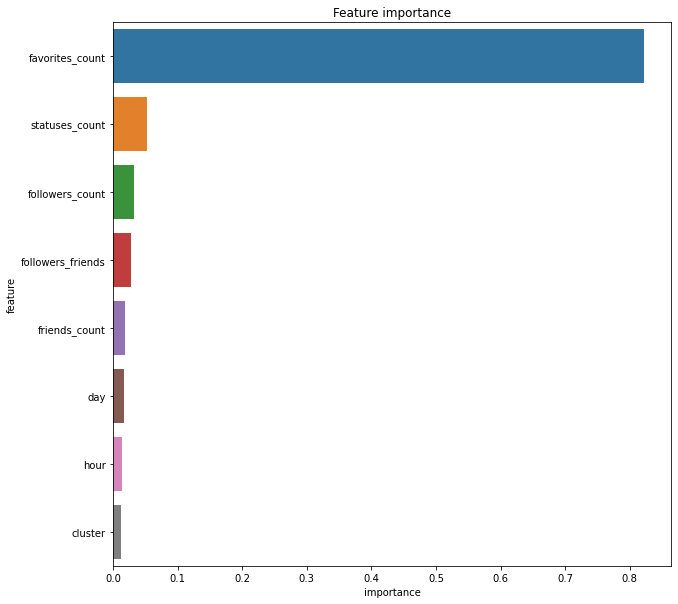

<AxesSubplot:>

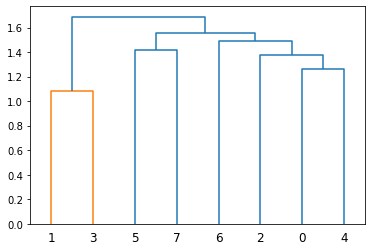

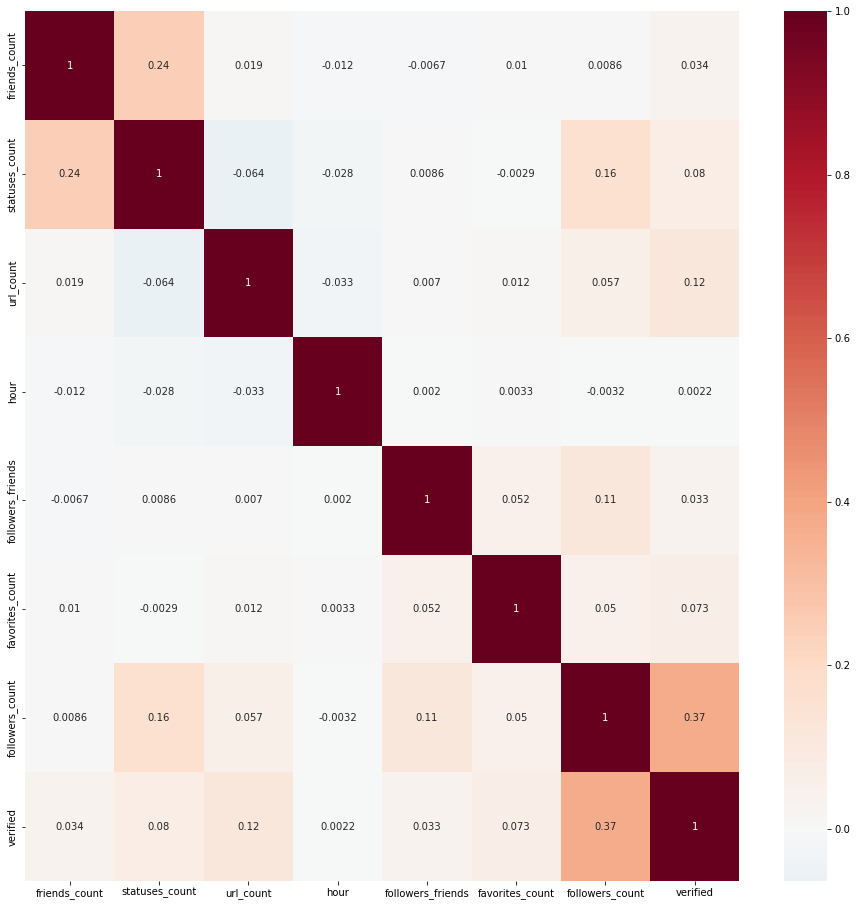

In [87]:
import seaborn as sbn
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_X_train.drop(
    remove, axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(
    by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_X_train.drop(remove, axis=1).corr()), no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_X_train.drop(
    ['TweetID'], axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sbn.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)


In [83]:
# plot model mse with number of top features
# TO DO
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest


### Models to consider
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]))